# Coursera Data Science Capstone: Battle of the Neighborhoods Notebook

## Description of the problem and a discussion of the background

In this scenario
- Where is the best place to park a food truck in Franklin County, Ohio?

People usually don't travel somewhere for a food truck.  So, in order to have as much traffic as possible, we want to go where people are already:
1. There
2. Hungry

Assumptions:
- We're allowed to park anywhere we want.

Locational considerations
- bars
- restaurants
- office buildings
- stadiums / arenas
- university campuses
  

## Notebook

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import requests
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans

### Get Franklin County Zip Code Data

I was surprised that I couldn't find any tables that had ['Zip Code', 'County', 'City', 'State'] as columns for either Ohio or the US, so I copied a list of zip codes in Franklin County, Ohio ([linked here](https://www.bestplaces.net/find/zip.aspx?county=39049&st=OH)), pasted them into Excel, then used the '=CONCAT("'",A1,"'",",")' function to add quotes and commas, and pasted them into the list below.

In [2]:
zip_code_city_list = [
    '43109 (Brice)',
    '43110 (Columbus)',
    '43119 (Columbus)',
    '43214 (Columbus)',
    '43215 (Columbus)',
    '43217 (Columbus)',
    '43219 (Columbus)',
    '43220 (Columbus)',
    '43222 (Columbus)',
    '43223 (Columbus)',
    '43224 (Columbus)',
    '43227 (Columbus)',
    '43228 (Columbus)',
    '43229 (Columbus)',
    '43231 (Columbus)',
    '43232 (Columbus)',
    '43235 (Columbus)',
    '43002 (Columbus)',
    '43004 (Columbus)',
    '43054 (Columbus)',
    '43201 (Columbus)',
    '43202 (Columbus)',
    '43203 (Columbus)',
    '43204 (Columbus)',
    '43205 (Columbus)',
    '43206 (Columbus)',
    '43207 (Columbus)',
    '43209 (Columbus)',
    '43210 (Columbus)',
    '43211 (Columbus)',
    '43212 (Columbus)',
    '43016 (Dublin)',
    '43017 (Dublin)',
    '43230 (Gahanna)',
    '43123 (Grove City)',
    '43125 (Groveport)',
    '43126 (Harrisburg)',
    '43026 (Hilliard)',
    '43137 (Lockbourne)',
    '43068 (Reynoldsburg)',
    '43221 (Upper Arlington)',
    '43081 (Westerville)',
    '43213 (Whitehall)',
    '43085 (Worthington)'
]

zip_codes = []
cities = []
for zip_city in zip_code_city_list:
    zip_codes.append(zip_city[0:5])
    cities.append(zip_city[7:-1])

zip_codes_df = pd.DataFrame(list(zip(zip_codes, cities)), columns=['zip_code', 'city'])
zips = list(zip_codes_df['zip_code'])
zip_codes_df.head()


,zip_code,city
0,43109,Brice
1,43110,Columbus
2,43119,Columbus
3,43214,Columbus
4,43215,Columbus


### Get Latitude + Longitude Data for each Zip Code

In [3]:
coords_df_load = pd.read_csv('https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/download/?format=csv&timezone=America/New_York&use_labels_for_header=true', sep=';')
coords_df_load.head()

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,71937,Cove,AR,34.398483,-94.39398,-6,1,"34.398483,-94.39398"
1,72044,Edgemont,AR,35.624351,-92.16056,-6,1,"35.624351,-92.16056"
2,56171,Sherburn,MN,43.660847,-94.74357,-6,1,"43.660847,-94.74357"
3,49430,Lamont,MI,43.010337,-85.89754,-5,1,"43.010337,-85.89754"
4,52585,Richland,IA,41.194129,-91.98027,-6,1,"41.194129,-91.98027"


In [4]:
coords_df = coords_df_load[['Zip', 'City', 'Latitude', 'Longitude']]

franklin_coords_df = coords_df.loc[coords_df['Zip'].isin(zips)].reset_index().drop(['index'], axis=1)
franklin_coords_df

,Zip,City,Latitude,Longitude
0,43081,Westerville,40.109513,-82.91606
1,43137,Lockbourne,39.818249,-82.98115
2,43223,Columbus,39.935263,-83.04558
3,43213,Columbus,39.966814,-82.87413
4,43228,Columbus,39.954363,-83.12300
5,43220,Columbus,40.047273,-83.06986
6,43221,Columbus,40.020630,-83.07655
7,43230,Columbus,40.039963,-82.87855
8,43224,Columbus,40.039914,-82.96772
9,43232,Columbus,39.924213,-82.86563


Now that we have a table of zip codes, city name, and coordinates for the area we're interested in, let's visualize the points on the map.

### Visualize Zip Codes on a Map

In [5]:
# Get the coordinates for the City of Columbus (for folium)
address = "Columbus"
geolocator = Nominatim(user_agent="columbus")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The coordinates for the City of Columbus are {}, {}.'.format(latitude, longitude))

The coordinates for the City of Columbus are 39.9622601, -83.0007065.


In [6]:
# Create a folium map around the coordinates of the city
map_columbus = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# Create a tags on each zip code
for lat, long, city, zip_code in zip(franklin_coords_df['Latitude'], franklin_coords_df['Longitude'], franklin_coords_df['City'], franklin_coords_df['Zip']):
    label = '{}, {}'.format(city, zip_code)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, long],
                        radius=5,
                        popup=label,
                        color='blue',
                        fill=True,
                        fill_opacity=0.1,
                        parse_html=False).add_to(map_columbus)  

map_columbus

Now that we have a visual map of the county we're interested in, we can use Foursquare API to get information about the existing venues.

### Get Venue Data for Franklin County from FourSquare

In [7]:
# Provide API Keys for connection
CLIENT_ID = "2Q2AQSZBXD1TK0EA5SGGOYPSSP2Q2IGHLDFY4YSZ0UL0EIDS"
CLIENT_SECRET_KEY= "OQUJ0TNNX1MSNBTPZWGHJIL20DMH1WVLFC2Y1FGFOSYA154A"
VERSION = "20180604" # Older API Version
LIMIT = 100
radius = 500

In [8]:
# Make a list to store the venues (to convert to df later)
venues_list = []

# Loop thru the cleansed coordinate dataframe, get the venues in them, then get the coordinates and categories of venues
for lat, long, city, zip_code in zip(franklin_coords_df['Latitude'], franklin_coords_df['Longitude'], franklin_coords_df['City'], franklin_coords_df['Zip']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET_KEY,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    results = requests.get(url).json()['response']['groups'][0]['items']
    for venue in results:
        venues_list.append((zip_code, 
                            city,
                            lat, 
                            long, 
                            venue['venue']['name'], 
                            venue['venue']['location']['lat'], 
                            venue['venue']['location']['lng'],  
                            venue['venue']['categories'][0]['name']))

In [9]:
# Convert the venues list to a dataframe and rename columns
venues_df = pd.DataFrame(venues_list)
venues_df.columns = ['zip_code', 'city', 'city_lat', 'city_long', 'venue', 'venue_lat', 'venue_long', 'venue_category']
venues_df.head()

,zip_code,city,city_lat,city_long,venue,venue_lat,venue_long,venue_category
0,43081,Westerville,40.109513,-82.91606,pointview soccer fields,40.106942,-82.912385,Soccer Field
1,43223,Columbus,39.935263,-83.04558,CVS pharmacy,39.932350,-83.048721,Pharmacy
2,43223,Columbus,39.935263,-83.04558,Walgreens,39.932417,-83.047267,Pharmacy
3,43223,Columbus,39.935263,-83.04558,Grandma's Pizza Harrisburg Pike,39.936522,-83.043110,Pizza Place
4,43223,Columbus,39.935263,-83.04558,Grandmas Pizza and Pasta,39.936699,-83.042770,Pizza Place


In [10]:
print("Venues collected: " + str(venues_df.shape[0] - 1))

Venues collected: 472


In [11]:
print("Count of distinct categories: " + str(len(venues_df['venue_category'].unique())))

Count of distinct categories: 154


In [12]:
# Create a dummy table of venue categories by zip
dummies_df = pd.get_dummies(venues_df['venue_category'], prefix = "",prefix_sep = "")
dummies_df.shape
dummies_df.head()

,ATM,Airport,American Restaurant,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,...,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Add the zip code to the dummy table
onehot_df = dummies_df
onehot_df['zip_code'] = venues_df['zip_code']

# move zip code to the first column
fixed_columns = list(onehot_df.columns[-1:]) + list(onehot_df.columns[:-1])
onehot_df = onehot_df[fixed_columns]

print(onehot_df.shape)
onehot_df.head()

(473, 155)


,zip_code,ATM,Airport,American Restaurant,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,...,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store
0,43081,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,43223,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43223,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,43223,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,43223,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Group the one hot values by postal code
venues_freq_df = onehot_df.groupby(['zip_code']).mean().reset_index()
print(venues_freq_df.shape)
venues_freq_df.head()

(42, 155)


,zip_code,ATM,Airport,American Restaurant,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,...,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store
0,43002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,43004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,43016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,43017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,43026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Get Most Popular Venue Categories by Zip Code

In [15]:
# Number of top venues to record (ie top 10)
num_top_venues = 10

# Generate column names
area_cols = ['zip_code']
freq_cols = []
for i in range(num_top_venues):
    freq_cols.append('#{} Most Common Venue Category'.format(i + 1))

cols = area_cols + freq_cols

# Build the dataframe
venues_df = pd.DataFrame(columns=cols)
venues_df['zip_code'] = venues_freq_df['zip_code']

print(venues_freq_df.shape)
for i in range(venues_freq_df.shape[0]):
    row_categories = venues_freq_df.iloc[i, :].iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    venues_df.iloc[i, 1:] = row_categories_sorted.index.values[0:num_top_venues]

venues_df.sort_values(['zip_code'], inplace=True)
venues_df

(42, 155)


,zip_code,#1 Most Common Venue Category,#2 Most Common Venue Category,#3 Most Common Venue Category,#4 Most Common Venue Category,#5 Most Common Venue Category,#6 Most Common Venue Category,#7 Most Common Venue Category,#8 Most Common Venue Category,#9 Most Common Venue Category,#10 Most Common Venue Category
0,43002,Gas Station,Supermarket,Pharmacy,Cosmetics Shop,Video Store,Deli / Bodega,Fabric Shop,Donut Shop,Dive Bar,Discount Store
1,43004,Light Rail Station,Garden Center,Women's Store,Flower Shop,Fast Food Restaurant,Farmers Market,Fabric Shop,Donut Shop,Dive Bar,Discount Store
2,43016,Gym,Swim School,Sandwich Place,Gastropub,Women's Store,Deli / Bodega,Fabric Shop,Donut Shop,Dive Bar,Discount Store
3,43017,Baseball Field,Gym,Football Stadium,Office,Cafeteria,Basketball Court,Women's Store,Farmers Market,Fabric Shop,Donut Shop
4,43026,Pizza Place,Women's Store,Department Store,Fast Food Restaurant,Farmers Market,Fabric Shop,Donut Shop,Dive Bar,Discount Store,Diner
5,43054,Park,History Museum,Shop & Service,Comic Shop,Department Store,Farmers Market,Fabric Shop,Donut Shop,Dive Bar,Discount Store
6,43068,Pizza Place,Bar,Bridal Shop,Ice Cream Shop,Dance Studio,Optical Shop,Diner,Fast Food Restaurant,Farmers Market,Fabric Shop
7,43081,Soccer Field,Women's Store,Department Store,Farmers Market,Fabric Shop,Donut Shop,Dive Bar,Discount Store,Diner,Deli / Bodega
8,43085,Grocery Store,Pub,Bakery,Deli / Bodega,Farmers Market,Fabric Shop,Donut Shop,Dive Bar,Discount Store,Diner
9,43109,Building,Pizza Place,Discount Store,Women's Store,Department Store,Farmers Market,Fabric Shop,Donut Shop,Dive Bar,Diner


### Preform Clustering to Determine the "Type" of Area which each Zip Code Belongs and Map

In [16]:
# Use K-Means to determine the "type" of area a zip code is, based on it's venues.

In [17]:
kclusters = 3

venues_freq_clustering_df = venues_freq_df.drop(['zip_code'], 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venues_freq_clustering_df)

clustered_df = franklin_coords_df

print(clustered_df.shape)
print(kmeans.labels_)
clustered_df['Cluster'] = kmeans.labels_

clustered_df = clustered_df.join(venues_df.set_index('zip_code'), on='zip_code')
clustered_df.sort_values(['Cluster'] + freq_cols, inplace=True)
clustered_df

(44, 4)
[2 1 2 2 0 2 2 2 2 0 0 2 2 0 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2
 2 2 2 2 2]


ValueError: Length of values does not match length of index

In [ ]:
# Create Folium map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, zip_code, cluster in zip(clustered_df['Latitude'], clustered_df['Longitude'], clustered_df['zip_code'], clustered_df['Cluster Labels']):
    label = folium.Popup(str(zip_code) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster - 1 ],
        fill=True,
        fill_color=rainbow[cluster - 1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In addition to the information about the venues in each zip code, it would also be helpful to have information about the people that live in each area.

### Get Demographic Information about Ohioans from IRS Website

#### Get Relative Financial Health of each Zip Code

In [18]:
income_df = pd.read_csv('oh_tax_income_by_zip_2016.csv') # from IRS website (https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2016-zip-code-data-soi)
franklin_income_df = income_df.loc[income_df['zip_code'].isin(zips)]

franklin_income_df.head()

,zip_code,no_less_25000,no_25000_to_50000,no_50000_to_75000,no_75000_to_100000,no_100000_to_200000,no_greater_200000,no_total
0,43004,3500,3330,2350,1540,1880,750,13350
1,43016,4620,3940,3410,2580,4420,2030,21000
2,43017,4960,2990,2320,2010,4300,3170,19750
3,43026,8310,6580,4690,3560,5820,1360,30320
4,43054,2590,2020,1730,1230,2560,2260,12390


#### Determine the Relative Size of each Zip Code

In [20]:
# Get information about the population sizes in general
franklin_income_df['size_rank'] = franklin_income_df['no_total'].rank(ascending=False)
franklin_income_df.sort_values(by='no_total', ascending=False).head()

,zip_code,no_less_25000,no_25000_to_50000,no_50000_to_75000,no_75000_to_100000,no_100000_to_200000,no_greater_200000,no_total,size_rank
10,43123,9610,8370,5570,3790,4520,700,32560,1.0
6,43081,8630,7450,5470,3840,5160,950,31500,2.0
3,43026,8310,6580,4690,3560,5820,1360,30320,3.0
37,43230,8000,7540,5140,3530,4580,900,29690,4.0
5,43068,9900,8750,4350,2470,2530,250,28250,5.0


#### Graph Total Population vs. Zip Code

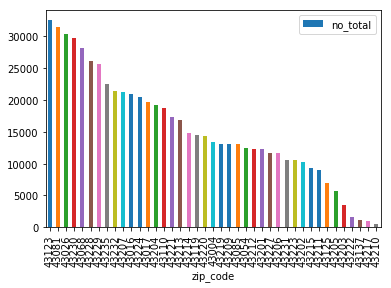

In [22]:
franklin_income_df.sort_values(by='no_total', ascending=False).plot(x='zip_code', y='no_total', kind='bar')

In [23]:
# Add a column for total number of people who make more than $50,000 per year (because they have more money to spend on going out) 
franklin_income_df['no_greater_50000'] = franklin_income_df['no_50000_to_75000'] + franklin_income_df['no_75000_to_100000'] + franklin_income_df['no_100000_to_200000'] + franklin_income_df['no_greater_200000']
# Add a column for the proportion of people making more than $50,000 relative to total population by zip
franklin_income_df['prop_greater_50000'] = franklin_income_df['no_greater_50000'] / franklin_income_df['no_total']
# Rank proportion greater $50,000
franklin_income_df['well_off_rank'] = franklin_income_df['prop_greater_50000'].rank(ascending=False)
franklin_income_df

,zip_code,no_less_25000,no_25000_to_50000,no_50000_to_75000,no_75000_to_100000,no_100000_to_200000,no_greater_200000,no_total,size_rank,no_greater_50000,prop_greater_50000,well_off_rank
0,43004,3500,3330,2350,1540,1880,750,13350,21.0,6520,0.488390,10.0
1,43016,4620,3940,3410,2580,4420,2030,21000,11.0,12440,0.592381,4.0
2,43017,4960,2990,2320,2010,4300,3170,19750,13.0,11800,0.597468,3.0
3,43026,8310,6580,4690,3560,5820,1360,30320,3.0,15430,0.508905,8.0
4,43054,2590,2020,1730,1230,2560,2260,12390,25.0,7780,0.627926,1.0
5,43068,9900,8750,4350,2470,2530,250,28250,5.0,9600,0.339823,21.0
6,43081,8630,7450,5470,3840,5160,950,31500,2.0,15420,0.489524,9.0
7,43085,3210,2670,2040,1490,2680,940,13030,24.0,7150,0.548734,5.0
8,43110,5990,5190,3040,1850,2230,390,18690,15.0,7510,0.401819,17.0
9,43119,4570,4220,2460,1530,1560,180,14520,19.0,5730,0.394628,18.0


#### Get the Density of Relatively Wealthy People by Zip Code

In [24]:
income_stats_df = franklin_income_df[['zip_code', 'well_off_rank', 'prop_greater_50000', 'no_greater_50000', 'no_total']]
income_stats_df.sort_values(by='prop_greater_50000', ascending=False)

,zip_code,well_off_rank,prop_greater_50000,no_greater_50000,no_total
4,43054,1.0,0.627926,7780,12390
30,43221,2.0,0.598616,10380,17340
2,43017,3.0,0.597468,11800,19750
1,43016,4.0,0.592381,12440,21000
7,43085,5.0,0.548734,7150,13030
25,43214,6.0,0.514189,7610,14800
26,43215,7.0,0.512352,4770,9310
3,43026,8.0,0.508905,15430,30320
6,43081,9.0,0.489524,15420,31500
0,43004,10.0,0.488390,6520,13350


#### Graph the Proportions of Weathly People by Zip Code

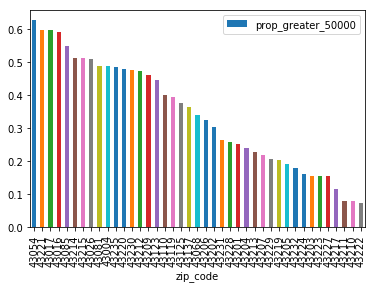

In [25]:
income_stats_df.sort_values(by='well_off_rank', ascending=True).plot(x='zip_code', y='prop_greater_50000', kind='bar')

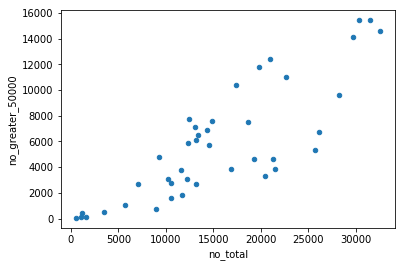

In [26]:
income_stats_df.plot(x='no_total', y='no_greater_50000', kind='scatter')

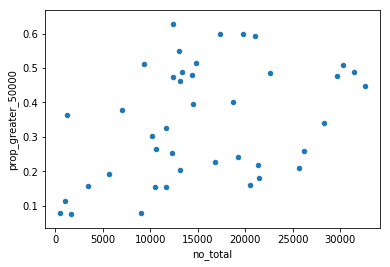

In [27]:
income_stats_df.plot(x='no_total', y='prop_greater_50000', kind='scatter')

#### Graph only the Top 5 Most Well-off Zip Codes

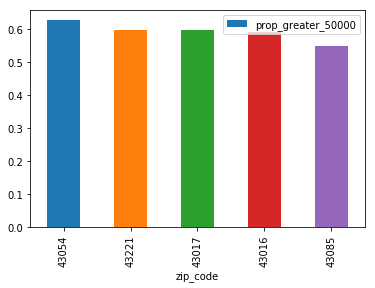

In [28]:
income_stats_df.sort_values(by='well_off_rank', ascending=True).head().plot(x='zip_code', y='prop_greater_50000', kind='bar')

#### Combine the Local Financial Statistics with the Most Popular Venue Categories by Zip Code

In [29]:
income_venues_df = pd.merge(income_stats_df, venues_df, on='zip_code', how='inner')
income_venues_df.sort_values(by='well_off_rank').head()

,zip_code,well_off_rank,prop_greater_50000,no_greater_50000,no_total,#1 Most Common Venue Category,#2 Most Common Venue Category,#3 Most Common Venue Category,#4 Most Common Venue Category,#5 Most Common Venue Category,#6 Most Common Venue Category,#7 Most Common Venue Category,#8 Most Common Venue Category,#9 Most Common Venue Category,#10 Most Common Venue Category
4,43054,1.0,0.627926,7780,12390,Park,History Museum,Shop & Service,Comic Shop,Department Store,Farmers Market,Fabric Shop,Donut Shop,Dive Bar,Discount Store
28,43221,2.0,0.598616,10380,17340,Playground,Construction & Landscaping,Food Truck,Theater,Women's Store,Diner,Farmers Market,Fabric Shop,Donut Shop,Dive Bar
2,43017,3.0,0.597468,11800,19750,Baseball Field,Gym,Football Stadium,Office,Cafeteria,Basketball Court,Women's Store,Farmers Market,Fabric Shop,Donut Shop
1,43016,4.0,0.592381,12440,21000,Gym,Swim School,Sandwich Place,Gastropub,Women's Store,Deli / Bodega,Fabric Shop,Donut Shop,Dive Bar,Discount Store
7,43085,5.0,0.548734,7150,13030,Grocery Store,Pub,Bakery,Deli / Bodega,Farmers Market,Fabric Shop,Donut Shop,Dive Bar,Discount Store,Diner


Subjective rank of best places to park a food truck in the top 5 most wealthy areas, based on popular venues and how likely they are to attract hungry people:
- Bad Venues: Direct competition with our food truck.
- Okay Venues: Places people go, but aren't necessarily there long enough to want a meal.
- Good Venues: Places that people go and stay long enough that they will probably want food.
- Great Venues: Places that a lot of people go to and they stay long enough that they'll definitely want food.

#### Manually Categorize the Top Venues that showed up in the Top 5 Wealthiest Zip Codes

In [30]:
# Assign labels to each type of venue
bad_venues = ['Fish & Chips Shop', 'Fast Food Restaurant', 'Cafeteria', 'Sandwich Place', 'Food Truck', 'Diner', 'Discount Store', 'Deli / Bodega']
okay_venues = ['Gym', 'Comic Shop', 'Department Store', 'Donut Shop', 'Bakery', 'Sporting Goods Shop', 'Lawyer', 'Flower Shop', "Women's Store", 'Construction & Landscaping', 'Shop & Service', 'Farmers Market', 'Fabric Shop', 'Grocery Store', 'Dive Shop']
good_venues = ['Dog Run', 'Theater', 'Playground', 'Swim School', 'History Museum', 'Gastropub']
great_venues = ['Park', 'Dive Bar', 'Baseball Field', 'Basketball Court', 'Football Stadium', 'Office', 'Pub']

#### Replace the Nominal Venue Categories with Values based on their Subjective Rank
- Give bad venues a score of 0, okay 1, good 2, great 3.
- Zip Code Score = (Normalized Size of Potential Customer Pool) * (Sum of the Venue Categories Score)
- Highest Zip Code Score is the area we will park our food truck.

In [32]:
income_venues_df_copy = income_venues_df.sort_values(by='well_off_rank').head()
numerical_income_venues_df = income_venues_df_copy.replace(bad_venues, 0).replace(okay_venues, 1).replace(good_venues, 2).replace(great_venues, 3)
factor = numerical_income_venues_df['no_greater_50000'].max()
numerical_income_venues_df['Score'] = numerical_income_venues_df['no_greater_50000']/factor * numerical_income_venues_df['#1 Most Common Venue Category'] + numerical_income_venues_df['#2 Most Common Venue Category'] + numerical_income_venues_df['#3 Most Common Venue Category'] + numerical_income_venues_df['#4 Most Common Venue Category'] + numerical_income_venues_df['#5 Most Common Venue Category'] + numerical_income_venues_df['#6 Most Common Venue Category'] + numerical_income_venues_df['#7 Most Common Venue Category'] + numerical_income_venues_df['#8 Most Common Venue Category'] + numerical_income_venues_df['#9 Most Common Venue Category'] + numerical_income_venues_df['#10 Most Common Venue Category']
numerical_income_venues_df

,zip_code,well_off_rank,prop_greater_50000,no_greater_50000,no_total,#1 Most Common Venue Category,#2 Most Common Venue Category,#3 Most Common Venue Category,#4 Most Common Venue Category,#5 Most Common Venue Category,#6 Most Common Venue Category,#7 Most Common Venue Category,#8 Most Common Venue Category,#9 Most Common Venue Category,#10 Most Common Venue Category,Score
4,43054,1.0,0.627926,7780,12390,3,2,1,1,1,1,1,1,3,0,12.876206
28,43221,2.0,0.598616,10380,17340,2,1,0,2,1,0,1,1,1,3,11.668810
2,43017,3.0,0.597468,11800,19750,3,1,3,3,0,3,1,1,1,1,16.845659
1,43016,4.0,0.592381,12440,21000,1,2,0,2,1,0,1,1,3,0,11.000000
7,43085,5.0,0.548734,7150,13030,1,3,1,0,1,1,1,3,0,0,10.574759


In [33]:
score_df = numerical_income_venues_df.sort_values(by='Score', ascending=False)
score_df[['zip_code','Score']]

,zip_code,Score
2,43017,16.845659
4,43054,12.876206
28,43221,11.668810
1,43016,11.000000
7,43085,10.574759


Dublin (43017), New Albany (43054), Upper Arlington (43221), Dublin (43016), Worthington (43085)

#### Based on the income levels and types of venues, Dublin, OH (43017) would be the best place to park our food truck in Franklin county.  It has a large and wealthy population, and the most popular venues are office, baseball field, and football stadium--all of which attract a lot of hungry people.

Note: the venues change depending on the day you run the program, so new venues will have to be categorized as bad, okay, good, and great next time.